# Isolating phyllotactic features from cherry tree
## Notebook 1: Feature Isolation and Analysis

In [1]:
# Standard python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from scipy import ndimage as ndi
import csv
import os

# Cherry tools
from radius import find_radii
from pith import find_center
from polar import save_polar_all
from helix_interpolation import get_helix

# Skimage
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops

# Scan constants
global THICKNESS 
global SPACING
THICKNESS = 0.625000
SPACING = 0.351562

In [2]:
# Helper functions.

# Write results to csv file
def write_out(filename, header, results): 
    with open(filename,mode="w") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)

        for r in results:
            writer.writerow(r)

# Test to see if a point is inside the circle created by the scan.
def inside_circle(p):
	s = 255
	return (p[0] - s)**2 + (p[1] - s)**2 < s**2

# Sign function
def sign(x):
	if x>0:
		return 1
	return -1

# Radians to degrees
def toDegrees(R):
	return R*(360/(2*np.pi))

# Euclidean distance
def dist(p1,p2):
	return np.power(np.power(p1[0]-p2[0],2) + np.power(p1[1]-p2[1],2), 0.5)

# Distance on unrolled cylinder with cirumference C
def cdist(p1,p2,C):
	#print(p1,p2)
	if abs(p1[0]-p2[0]) < (C/2):
		return dist(p1,p2)
	#print("C/2 = ",C/2)
	#print("diff = ",abs(p1[0]-p2[0]) )
	return np.power(np.power(C - abs(p2[0]-p1[0]),2) + np.power(p1[1]-p2[1],2), 0.5)

In [3]:
# Files to parse
f = lambda i: '../data/cherry_stump/processed/cherry' + str(i).zfill(4) + ".npy" 
id_range = list(range(100, 1811, 1))#range(25,1830,1)
file_names = [f(i) for i in id_range]

# Create out directory
if not os.path.exists("./out"):
    os.makedirs("./out")

## Step 1: Find pith locations

In [4]:
# Find pith locations (centers)
lower_bound = 819-100 # For intensity range
seed = [300, 200] # First center location #[265,199]
first_slice = id_range[0] # First slice to consider
result_rows = find_center(file_names, seed, lower_bound,inside_circle, first_slice,verbose=False)

In [5]:
# Write center coordinates out
write_out('./out/center_coords.csv', ["img_id", "x", "y", "region_size"], result_rows)

In [6]:
# Create data frame
center_table = pd.read_csv("./out/center_coords.csv", index_col=0)
center_table.head()

,x,y,region_size
img_id,,,
100,212,271,43
101,213,271,38
102,213,271,37
103,213,271,41
104,213,271,37


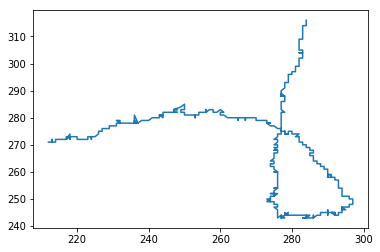

In [7]:
# Plot pith location
plt.plot(center_table['x'],center_table['y'])
plt.show()

## Step 2: Find radii of each slice

In [8]:
# Find radii (expensive!)
radii_results = find_radii(inside_circle, file_names, 100, center_table,99,verbose=False)

In [9]:
# Save radii
write_out("./out/radius.csv", ["img_id", "r"], radii_results)

In [10]:
# Create dataframe for radius
radius_table = pd.read_csv("./out/radius.csv",index_col=0)
radius_table.head()

,r
img_id,
100,129.294237
101,129.025191
102,128.413395
103,127.775193
104,127.929667


In [25]:
# Add adjusted radius and circumference 
radius_table['r_adjusted'] = radius_table['r'] * SPACING
radius_table['C_adjusted'] = 2*np.pi*radius_table['r_adjusted'] 

# Compute median and standard error
# https://stats.stackexchange.com/questions/59838/standard-error-of-the-median
# The magic number computes the standard error of the median
magic_number = np.sqrt(np.pi/2) 
med_r = float(radius_table['r_adjusted'].median())
stdev_r = float(magic_number*radius_table['r_adjusted'].sem())
med_C = float(radius_table['C_adjusted'].median())
stdev_C = float(magic_number*radius_table['C_adjusted'].sem())

# Report sizes of things
print("median radius =",med_r,"mm (+/-",stdev_r,"mm)")
print("median circumference =",med_C,"mm (+/-",stdev_C,"mm)")
print("tallest height =", (1852-10) * THICKNESS,"mm")
print("shortest height =", (1804-39) * THICKNESS,"mm")

median radius = 47.17354233456737 mm (+/- 0.13284349292645797 mm)
median circumference = 296.4001080841679 mm (+/- 0.8346802829099369 mm)
tallest height = 1151.25 mm
shortest height = 1103.125 mm


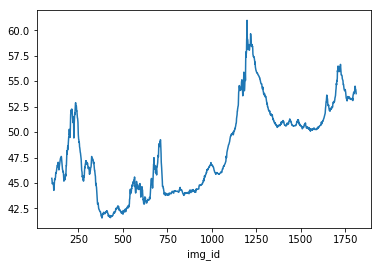

In [28]:
radius_table['r_adjusted'].plot()
plt.show()

## Step 3: Convert images to polar coordinates

In [13]:
# Save polar slices in parallel (very expensive!)
# Create out directory
if not os.path.exists("./out/polar"):
    os.makedirs("./out/polar")
save_polar_all("./out/polar",center_table,radius_table,id_range,num_cores = 8)

In [16]:
# Helper function to load polar images
def get_polar(img_id):
	return np.load("./out/polar/rad_polar"+str(img_id).zfill(4)+'.npy') 

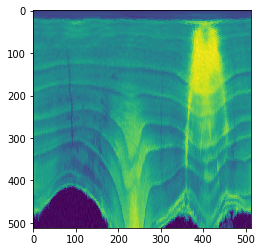

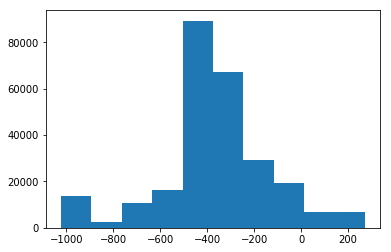

In [17]:
# Sample polar image and histogram
im = get_polar(100)
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()

## Step 4: Assemble boundary image

In [18]:
# Threshold polar images and then find surface summary data

thresh = -400 #-600
all_means = []
for img_id in id_range:
    # Get image
	im = get_polar(img_id)
    
    # Threshold
	im[(im < thresh)] = np.nan

	# Find means over theta-direction 
	all_means.append(np.nanmean(im,axis=0))

# Stack means together
all_points = np.column_stack(all_means) 

# Flip for correct tree orientation!
all_points_flip = np.fliplr(all_points)

# Save
np.save("./out/heat_map_mean.npy",all_points_flip)
print("Done")


Done


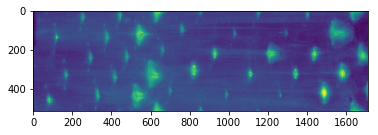

In [19]:
# Plot boundary image
plt.imshow(all_points_flip)
plt.show()

## Step 5: Find blobs and their centroids

In [20]:
# Compute average radius
r = radius_table['r_adjusted'].median()

# Load image
org_img = np.load("./out/heat_map_mean.npy")
org_shape = org_img.shape

# Make 3 stacked copies of image
image = np.vstack([org_img]*3)

# Threshold
global_thresh = threshold_otsu(image)
binary_global = image > global_thresh
image = binary_global

# Remove small objects
image, num_labels = ndi.label(image)
image = remove_small_objects(image,min_size=100)#remove_small_objects(image,min_size=150)

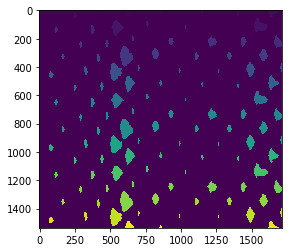

In [21]:
# Show blobs
plt.imshow(image)
plt.show()

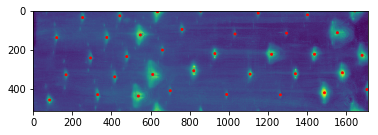

In [22]:
# Find index centers
#largearray = image
#idx = np.indices(largearray.shape).reshape(largearray.ndim, largearray.size)
#label, mean = npi.group_by(largearray, axis=None).mean(idx, axis=1)
props = regionprops(image)
mean = np.array([props[i].centroid for i in range(len(props))]).T

# Add missing one!
a,b = (114.61904761904762, 1295.095238095238)
mean = np.hstack([mean,[[a + org_shape[0]], [b]]])

# Keep only means in the middle third
adjusted_means = []
for i in range(1,mean.shape[1]):
	if (org_shape[0] <= mean[0,i]) and (mean[0,i] < 2*org_shape[0]):
		adjusted_means.append((mean[1,i], mean[0,i] % org_shape[0]))

# Plot circles
ax = plt.gca()
ax.imshow(org_img)
for m in adjusted_means:
	ax.add_artist(plt.Circle(m, 5, color='red'))
plt.show()

In [23]:
# Compute "raw coordinates"
raw_coords = []
for m in adjusted_means:
	theta = (m[1]/org_shape[0])*(2*np.pi*r) % (2*np.pi*r)
	z = m[0] * THICKNESS
	raw_coords.append((theta,z))

# Move zero
moved_points = []
min0 = min([m[0] for m in adjusted_means])
for m in adjusted_means:
	moved_points.append((m[0] - min0, m[1]))

# Find min1 based on min0
min1 = adjusted_means[np.argmin(np.array([m[0] for m in adjusted_means]))][1]

# Adjust to spatial coordinates
actual_points = []
for m in moved_points:
	theta_cm = ((m[1]-min1) / org_shape[0]) * (2*np.pi*r) % (2*np.pi*r)
	z_cm = (m[0]) * THICKNESS
	actual_points.append((theta_cm,z_cm))

print("Number of nodes",len(actual_points))

# Save data
np.savetxt('./out/meristem_coords.csv', actual_points, delimiter=',')
np.savetxt('./out/raw_meristem_coords.csv', raw_coords, delimiter=',')

Number of nodes 36


---
## Find intersection angles between paristichies

In [24]:
# Given (m,n), find average intesection angle

# Load coordinates
S = np.loadtxt("./out/raw_meristem_coords.csv",delimiter=",")
N = S.shape[0]
S = S[np.argsort(S[:, 1])]

# Radius and circumference
r = radius_table['r_adjusted'].median()
C = 2 * np.pi * r  

# (m,n) pairs to try
pairs = [(2,3),(3,5),(5,8)]

# Loop through pairs
for jump1, jump2 in pairs:
	angles = []
	small_angles = {0:[],1:[],2:[],3:[]}

	# Starting vertex
	for k in range(N):
		k_angles = []

		neighbors = [k-jump1,k-jump2,k+jump1,k+jump2]
		triangles = []

		# Look at pairs of indices
		for j in range(4):
			n1 = neighbors[j]
			n2 = neighbors[(j+1) % 4]

			# Check if indices are in bounds
			if n1 < N and n1 >= 0 and n2 < N and n2 >= 0:
				triangles.append((n1,n2))

		# Consider each valid triangle
		for T in triangles:

			# Law of Cosines
			a = cdist(S[k,:], S[T[0],:], C)
			b = cdist(S[T[0],:], S[T[1],:], C)
			c = cdist(S[T[1],:], S[k,:], C)
			B = np.arccos((np.power(a,2) + np.power(c,2) - np.power(b,2))/(2*a*c))

			# Report difference from 90
			ang = toDegrees(B)

			angles.append(abs(90-ang))
			k_angles.append(ang)
			
		if len(k_angles) == 4:
			k_angles = sorted(k_angles)
			for i in range(4):
				small_angles[i].append(k_angles[i])

	a1 = sum(small_angles[0] + small_angles[1])/len(small_angles[0] + small_angles[1])
	a2 = sum(small_angles[2] + small_angles[3])/len(small_angles[2] + small_angles[3])
	print("(",jump1,",",jump2,")")
	print("Local means:", a1,a2)
	print("Sum of local means:",a1+a2)
	print("Avg angle deviation:",sum(angles)/len(angles))
	print("Avg angle:",abs((sum(angles)/len(angles)-90)))


( 2 , 3 )
Local means: 78.0690182118755 101.93098178812453
Sum of local means: 180.00000000000003
Avg angle deviation: 12.09022901081001
Avg angle: 77.90977098919
( 3 , 5 )
Local means: 35.40357604357031 144.5964239564297
Sum of local means: 180.0
Avg angle deviation: 54.79015549946197
Avg angle: 35.20984450053803
( 5 , 8 )
Local means: 14.701786125628661 165.29821387437136
Sum of local means: 180.00000000000003
Avg angle deviation: 75.24945952815749
Avg angle: 14.750540471842513
